# ARIMA

This model can predict several prices in the future.

## Importing libraries

In [119]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import csv
import warnings
from pandas import Series


# Files
from indicators import get_momentum, get_RSI, get_sma, plot_stock_prices_prediction
from util import fetchOnlineData, slice_df

# Plot
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import tree, metrics, neighbors

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ARIMA
import statsmodels
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf

# TA Library (https://github.com/bukosabino/ta)
from ta import *

# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools



## Initial variables

In [2]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

## Getting data from Yahoo

In [3]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday)

[*********************100%***********************]  1 of 1 downloaded


In [670]:
# Normalize the prices Dataframe
normed = portf_value.copy()

In [671]:
# Convert price column to float
#normed[symbol] = pd.to_numeric(normed[symbol], downcast='float', errors='coerce').fillna(0)

In [672]:
normed.info()
normed.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-03-09 to 2019-03-08
Data columns (total 1 columns):
Adj Close    251 non-null float64
dtypes: float64(1)
memory usage: 3.9 KB


,Adj Close
Date,
2018-03-09,76.620003
2018-03-12,77.559998
2018-03-13,75.970001
2018-03-14,77.199997
2018-03-15,79.419998


## Getting indicator values

In [673]:
def get_indicators(normed, symbol):

    # Compute momentum
    sym_mom = get_momentum(normed[symbol], window=10)

    # ****Relative Strength Index (RSI)****
    # Compute RSI
    rsi_value = get_RSI(normed[symbol], 7)

    # ****Simple moving average (SMA)****
    # Compute SMA
    sma, q = get_sma(normed[symbol], window=10)
    return sym_mom, sma, q, rsi_value

#normed = scaling_data(normed, symbol)

normed['date'] = portf_value.index
normed.set_index('date', inplace=True)
normed.rename(columns={'Adj Close': symbol}, inplace=True)


In [674]:
# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(normed, symbol)


# Create momentum column
normed['Momentum'] = sym_mom

# Create SMA column
normed['SMA'] = sma

# Create SMA column
normed['RSI'] = rsi_value

date
2018-03-23   -0.047246
2018-03-26   -0.022563
2018-03-27   -0.038700
2018-03-28   -0.059067
2018-03-29   -0.067741
2018-04-02   -0.103880
2018-04-03   -0.093911
2018-04-04   -0.120779
2018-04-05   -0.111310
2018-04-06   -0.094140
2018-04-09   -0.062466
2018-04-10   -0.066350
2018-04-11   -0.033959
2018-04-12   -0.028910
2018-04-13   -0.064155
2018-04-16   -0.023464
2018-04-17    0.007940
2018-04-18    0.040276
2018-04-19    0.038051
2018-04-20    0.051961
2018-04-23    0.021186
2018-04-24   -0.021475
2018-04-25   -0.032318
2018-04-26   -0.010490
2018-04-27    0.006350
2018-04-30    0.002288
2018-05-01   -0.016880
2018-05-02   -0.029176
2018-05-03   -0.022771
2018-05-04    0.023220
                ...   
2019-01-25    0.033434
2019-01-28    0.037214
2019-01-29    0.040135
2019-01-30    0.083466
2019-01-31    0.072312
2019-02-01    0.065133
2019-02-04    0.058323
2019-02-05    0.111728
2019-02-06    0.112454
2019-02-07    0.071094
2019-02-08    0.050598
2019-02-11    0.050291
2019-0

In [675]:
normed.info()
# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-03-09 to 2019-03-08
Data columns (total 4 columns):
AABA        251 non-null float64
Momentum    241 non-null float64
SMA         242 non-null float64
RSI         251 non-null float64
dtypes: float64(4)
memory usage: 9.8 KB


,AABA,Momentum,SMA,RSI
date,,,,
2018-03-09,76.620003,0.000000,0.000000,56.744170
2018-03-12,77.559998,0.000000,0.000000,56.744170
2018-03-13,75.970001,0.000000,0.000000,56.744170
2018-03-14,77.199997,0.000000,0.000000,56.744170
2018-03-15,79.419998,0.000000,0.000000,56.744170
2018-03-16,79.900002,0.000000,0.000000,56.744170
2018-03-19,77.839996,0.000000,0.000000,56.744170
2018-03-20,79.070000,0.000000,0.000000,61.838325
2018-03-21,78.070000,0.000000,0.000000,55.624824


## Checking missing data

In [676]:
#missing data
total = normed.isnull().sum().sort_values(ascending=False)
percent = (normed.isnull().sum()/normed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

          Total  Percent
RSI           0      0.0
SMA           0      0.0
Momentum      0      0.0
AABA          0      0.0


## Correlation matrix

--------------- CORRELATIONS ---------------
              AABA  Momentum       SMA       RSI
AABA      1.000000   0.27371  0.145045  0.397336
Momentum  0.273710   1.00000 -0.002980  0.869540
SMA       0.145045  -0.00298  1.000000 -0.023346
RSI       0.397336   0.86954 -0.023346  1.000000


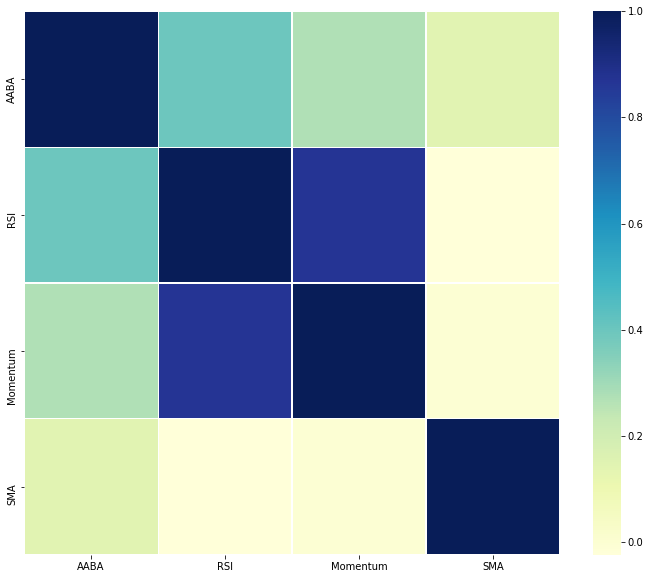

In [677]:
corr_df = normed.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
print(corr_df)

# Adj Close correlation matrix
corrmat = normed.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, symbol)[symbol].index
cm = np.corrcoef(normed[cols].values.T)
f, ax = plt.subplots(figsize =(12, 10)) 
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 
plt.show()

### Setting up the Target variable or the desired output.

In [678]:
# Define X and y
feature_cols = ['Momentum', 'RSI']
X = normed[feature_cols]
y = normed[symbol]

### Split the data

In [679]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

# ARIMA Model

## Auto Arima Forecast

In [701]:
import pmdarima as pm
model = pm.auto_arima(y_train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=598.488, BIC=604.806, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=600.167, BIC=609.644, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 1); AIC=600.028, BIC=609.505, Fit time=0.024 seconds
Total fit time: 0.101 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  174
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -297.244
Method:                           css   S.D. of innovations              1.336
Date:                Sun, 17 Mar 2019   AIC                            598.488
Time:                        21:43:07   BIC                            604.806
Sample:                             1   HQIC                           601.051
                                                                              
                 coef    std err        

## Interpret the residual plots in ARIMA model

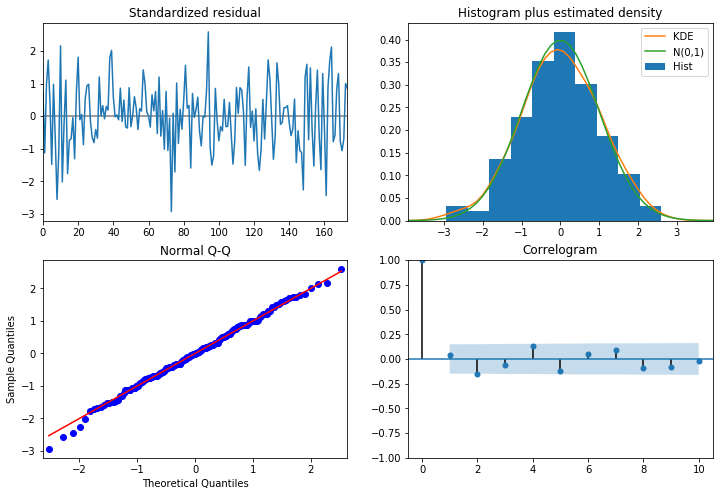

In [702]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

### Interpretation

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

## Forecasting

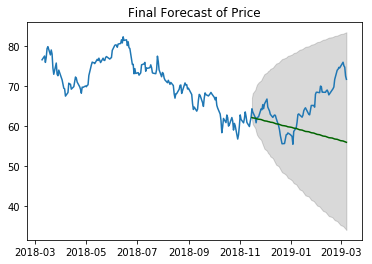

In [703]:
n_periods = y_test.size
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(normed[symbol]), len(normed[symbol])+n_periods)

fc_series = pd.Series(fc, index=y_test.index)
lower_series = pd.Series(conf[:, 0], index=y_test.index)
upper_series = pd.Series(conf[:, 1], index=y_test.index)

# Plot
plt.plot(normed[symbol])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Price")
plt.show()

## Optimal ARIMA model 



Find the optimal ARIMA model manually using Out-of-Time Cross validation.

In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

### Forecasting

In [682]:
# Create Training and Test
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]

In [688]:
# Build Model
fitted = model.fit(y_train)  

# Forecast
fc, se, conf = fitted.forecast(y_test.size, alpha=0.05)  # 95% conf

AttributeError: 'ARIMA' object has no attribute 'forecast'

In [664]:
# Make as pandas series
fc_series = pd.Series(fc, index=y_test.index)
lower_series = pd.Series(conf[:, 0], index=y_test.index)
upper_series = pd.Series(conf[:, 1], index=y_test.index)

In [665]:
# Train values dataframe for plotting
df_0 = pd.DataFrame()
df_0['Train Values'] = y_train.values
df_0['date'] = X_train.index
df_0.set_index('date', inplace=True)  

# Prediction and test values for plotting
df_1 = pd.DataFrame()
df_1['predictions'] = fc_series
df_1['y_test'] = y_test.values


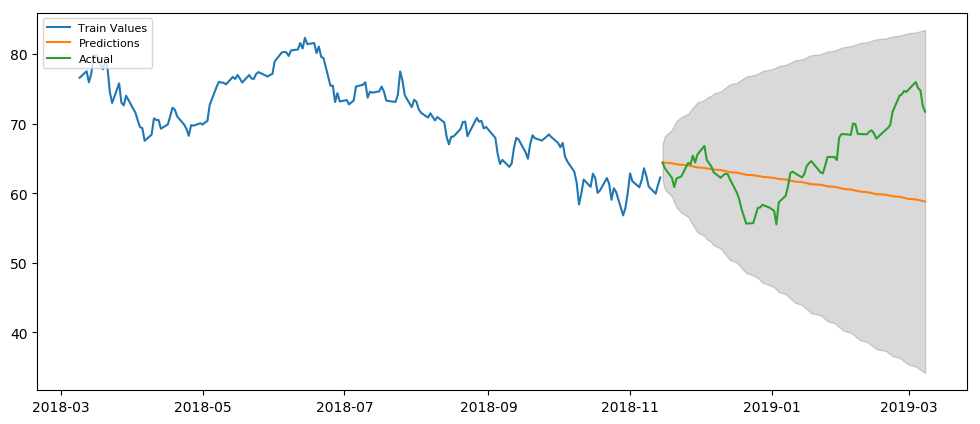

In [666]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_0['Train Values'], label='Train Values')
plt.plot(df_1['predictions'], label='Predictions')
plt.plot(df_1['y_test'], label='Actual')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Evaluate The Model

### Showing summary

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  174
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -297.908
Method:                       css-mle   S.D. of innovations              1.341
Date:                Sun, 17 Mar 2019   AIC                            601.816
Time:                        20:22:18   BIC                            611.293
Sample:                             1   HQIC                           605.660
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0755      0.110     -0.689      0.492      -0.290       0.139
ma.L1.D.y      0.0784      0.088      0.888      0.376      -0.095       0.251
                                    Roots           

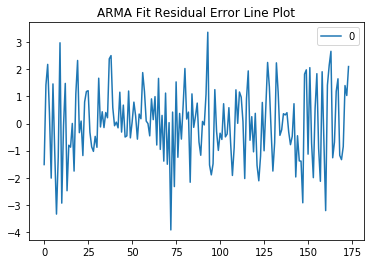

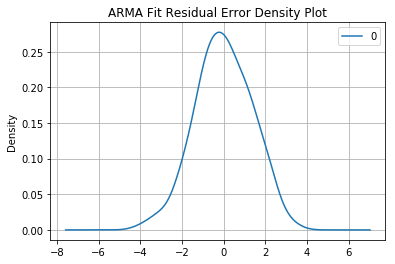

                0
count  174.000000
mean     0.000666
std      1.344554
min     -3.927139
25%     -0.876004
50%      0.005851
75%      1.025236
max      3.370871


In [667]:
print(fitted.summary())
# plot residual errors
residuals = pd.DataFrame(fitted.resid)
residuals.plot()
plt.title("ARMA Fit Residual Error Line Plot")
plt.show()
residuals.plot(kind='kde')
plt.title("ARMA Fit Residual Error Density Plot")
plt.grid("on")
plt.show()
print(residuals.describe())

### Correlation

A way to visualize and evaluate the accuracy of a regression algorithm is to look at the relationship between predicted and actual values of our dependant variable Y.

A value along the horizontal access is the prediction and along the vertical axis is what the ground truth is.

You'll get an answer somewhere between -1 and +1. Where +1 means they're strongly correlated, -1 means they're inversely correlated, and 0 means there's essentially no correlation at all between them.


In [114]:
print('Correlation: \n', np.corrcoef(pred_df['Forecast'], pred_df['Price']))

Correlation: 
 [[1.         0.97454963]
 [0.97454963 1.        ]]


### Plot correlation matrix

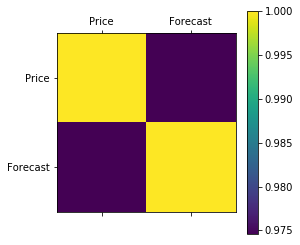

In [123]:
plt.matshow(pred_df.corr())
plt.xticks(range(len(pred_df.columns)), pred_df.columns)
plt.yticks(range(len(pred_df.columns)), pred_df.columns)
plt.colorbar()
plt.show()

### Plot slope line and elipse

So if it's a nice oval that fits close to the slope line, we usually have a high correlation. If it's a big round thing we've got poor correlation.


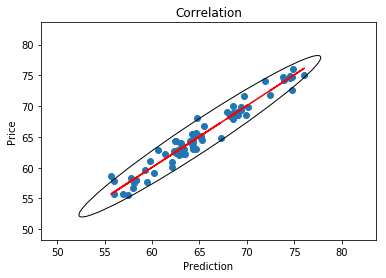

In [131]:
# Slope line
a = pred_df['Forecast']
b = pred_df['Price']
# Find the slope and intercept of the best fit line
slope, intercept = np.polyfit(a, b, 1)

# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in a]

# Create an ellipse
cov = np.cov(a, b)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)

ax = plt.subplot(111, aspect='auto')

ell = Ellipse(xy=(np.mean(a), np.mean(b)),
              width=lambda_[0]*5, height=lambda_[1]*5,
              angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='black')
ell.set_facecolor('none')

# Max and min values for lim
maxlim = max(b) * 1.1
minlim = min(b) / 1.15
ax.add_artist(ell)
ax.set(xlim=[minlim, maxlim], ylim=[minlim, maxlim])

plt.scatter(a, b)
plt.plot(a, abline_values, 'r')
plt.title("Correlation")
plt.xlabel('Prediction')
plt.ylabel("Price")
plt.show()



## Saving an ARIMA Time Series Forecasting Model

The statsmodels library provides an implementation of ARIMA for use in Python. ARIMA models can be saved to file for later use in making predictions on new data. There is a bug in the earlier versions to 0.9 of the statsmodels library that prevents saved models from being loaded.


In [27]:
print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.9.0


In [222]:
# save model
model_fit.save('arima_model.pkl')


## Loading a model and predicting future prices

In [244]:
# load model
model = ARIMAResults.load('arima_model.pkl')

forecast_lookback = 365
lookback_date = dt.date.today() - dt.timedelta(forecast_lookback)
dates = pd.date_range(lookback_date, periods=forecast_lookback) 
df_prices = slice_df(portf_value, dates) 

forecast_date = dt.date.today()
forecast_time = 20

In [245]:
# Bussines days
start = forecast_date.strftime("%Y-%m-%d")
rng = pd.date_range(pd.Timestamp(start),  periods=forecast_time, freq='B')
#bussines_days = rng.strftime('%Y-%m-%d')

forecast = model.forecast(steps=forecast_time)
forecast[0]

array([72.45023513, 72.55209165, 72.7795627 , 72.59723393, 72.62239827,
       72.5137025 , 72.5463722 , 72.46598259, 72.47227699, 72.40803376,
       72.40294858, 72.35144458, 72.3385448 , 72.29527898, 72.27763124,
       72.24023   , 72.21982087, 72.18659196, 72.16469106, 72.13452847])

In [246]:
# Setting dates for dataframe
df=pd.DataFrame(forecast[0])
df['date'] = rng
df.set_index('date', inplace=True)
df.rename(columns = {0:'Price'}, inplace=True)

## Plotting predictions

From https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

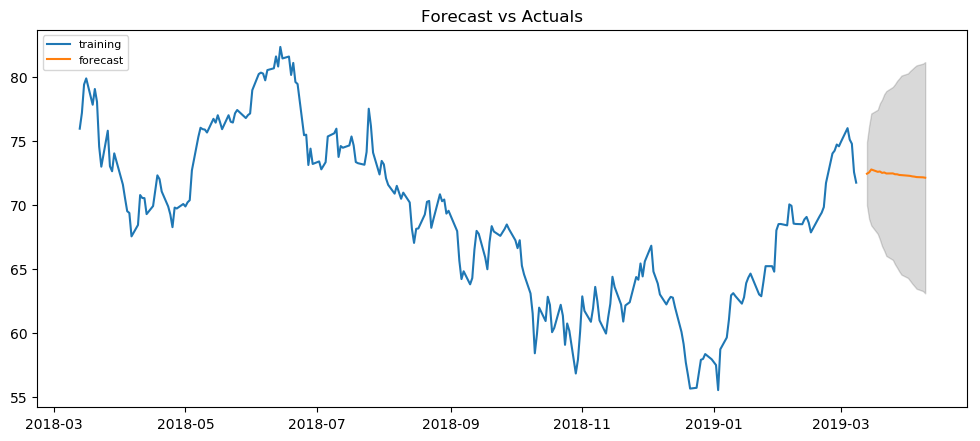

In [247]:


# Forecast
fc, se, conf = model.forecast(forecast_time, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=rng)
lower_series = pd.Series(conf[:, 0], index=rng)
upper_series = pd.Series(conf[:, 1], index=rng)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_prices['Adj Close'], label='training')
#plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()